In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
df = pd.read_csv('simresults_int_10000.csv')

observed_values = {
    'yel': 34,
    'grn': 68,
    'blu': 39,
    'cnt': 94,
    'blv': 60
}

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

name_map = {
    'cnt': 'Contrast + UV',
    'blu': 'Blue',
    'blv': 'Blue + UV',
    'grn': 'Green',
    'yel': 'Yellow'
}

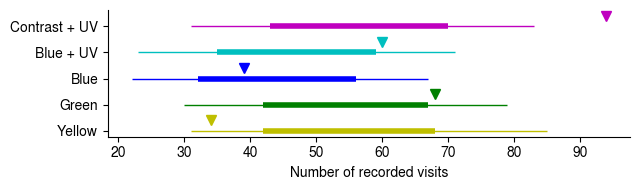

In [17]:
# new_order = ['cnt', 'blv', 'blu', 'grn', 'yel']
new_order = ['yel', 'grn', 'blu', 'blv', 'cnt']
plt.figure(figsize=(6.5, 2))

for i, col in enumerate(new_order):
    data = df[col].dropna()
    min_val, max_val = data.min(), data.max()
    observed = observed_values[col]
    ci_low, ci_high = np.percentile(data, [2.5, 97.5])
    plt.hlines(y=i, xmin=min_val, xmax=max_val, color=color_map[col], linewidth=1)
    plt.hlines(y=i, xmin=ci_low, xmax=ci_high, color=color_map[col], linewidth=4)
    plt.plot(observed, i + 0.4, marker='v', color=color_map[col], markersize=7)

plt.yticks(ticks=range(len(new_order)), labels=new_order)
mapped_labels = [name_map.get(col, col) for col in new_order]
plt.yticks(ticks=range(len(new_order)), labels=mapped_labels)
plt.xlabel('Number of recorded visits')
# plt.ylabel('Lure color')
plt.tight_layout()
plt.savefig('figs/simulation_line_interval.png', format='png', dpi=300)